In [1]:
%pip install -q matplotlib pandas tqdm m2stitch
%pip install -q git+https://github.com/yfukai/BaSiCpy@autotune

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


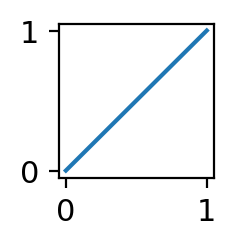

In [7]:
from basicpy import BaSiC, datasets
from matplotlib import pyplot as plt
import numpy as np
from hyperactive import Hyperactive
import pandas as pd
from m2stitch import stitch_images

plt.rcParams["font.family"] = ""
plt.figure(figsize=(1, 1))
plt.plot(range(2))

In [3]:
brain_wsi_image = datasets.wsi_brain()

In [4]:
brain_wsi_image.shape

(63, 128, 128)

In [5]:
def compose_image(img):
    img_composed = np.empty(
        (
            img.shape[1] * 7,
            img.shape[2] * 9,
        )
    )

    y = 0
    x = img.shape[2] * 8

    rows = []
    cols = []
    for j, im in enumerate(img):
        img_composed[y : y + img.shape[1], x : x + img.shape[2]] = im
        rows.append(y // img.shape[1])
        cols.append(x // img.shape[2])
        if (y // img.shape[2]) % 2 == 0:
            x -= img.shape[2]
            if x < 0:
                x = 0
                y += img.shape[1]
        else:
            x += img.shape[2]
            if x > img.shape[2] * 8:
                x = img.shape[2] * 8
                y += img.shape[1]
    return img_composed, rows, cols

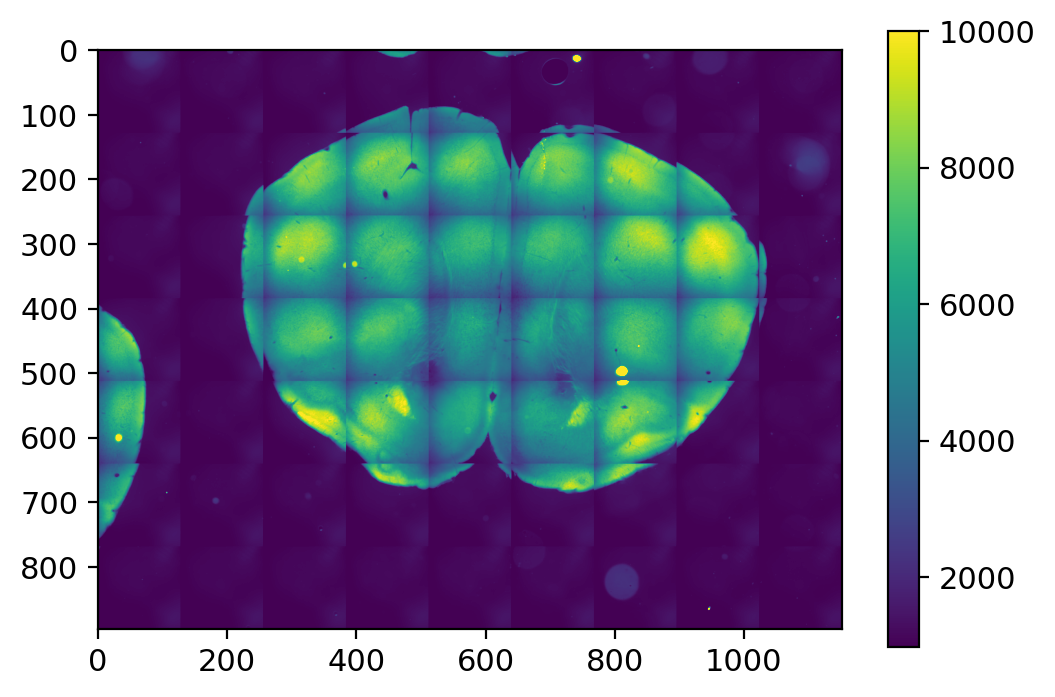

In [8]:
composed, rows, cols = compose_image(brain_wsi_image)
plt.imshow(composed, vmin=970, vmax=10000)
plt.colorbar()

In [9]:
basic = BaSiC(
    get_darkfield=True,
)

In [10]:
print(
    basic.smoothness_flatfield, basic.smoothness_darkfield, basic.sparse_cost_darkfield
)

1.0 1.0 0.01


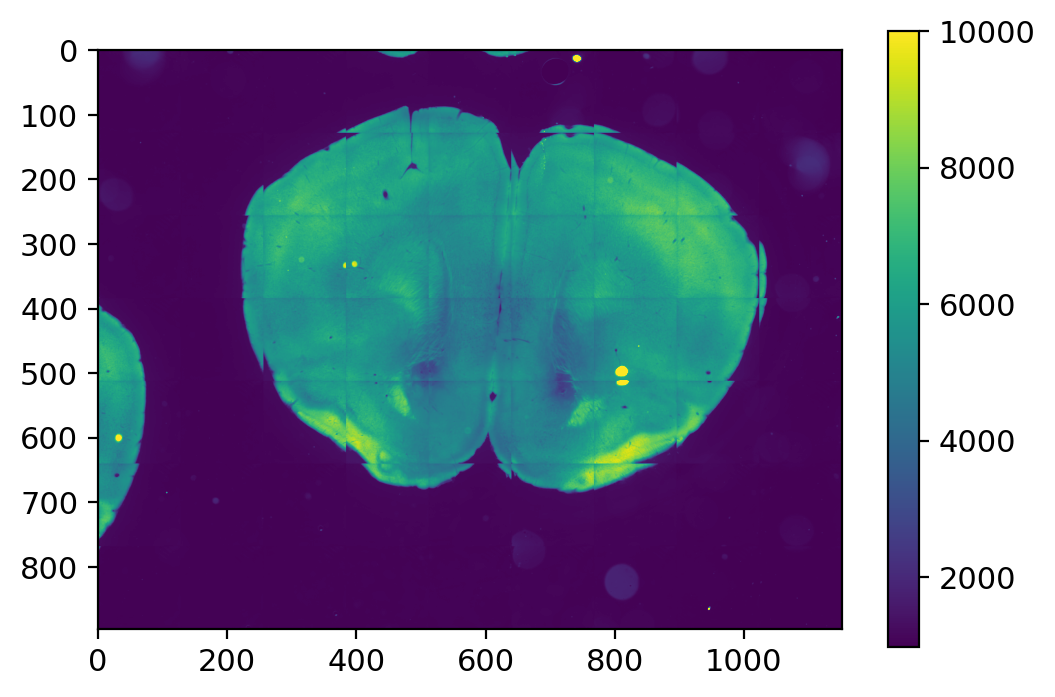

In [12]:
transformed1 = basic.fit_transform(brain_wsi_image)
composed, rows, cols = compose_image(transformed1)
plt.imshow(composed, vmin=970, vmax=10000)
plt.colorbar()

In [13]:
basic.autotune(brain_wsi_image, early_stop=True, n_iter=100)

[0] fit_and_calc_entropy (Hill Climbing):   3%|          | 3/100 [00:39<21:17, 13.17s/it, best_iter=0, best_pos=[4 1 1], best_score=-7.182954511583625]



Results: 'fit_and_calc_entropy'  
   Best score: -7.1825684136866785  
   Best parameter set:
      'smoothness_flatfield'  : 0.021544346900318832  
      'smoothness_darkfield'  : 0.001  
      'sparse_cost_darkfield' : 0  
   Best iteration: 0  
 
   Random seed: 236373508  
 
   Evaluation time   : 39.491854429244995 sec    [99.99 %]
   Optimization time : 0.003945589065551758 sec    [0.01 %]
   Iteration time    : 39.49580001831055 sec    [2.53 iter/sec]
 


In [14]:
print(
    basic.smoothness_flatfield, basic.smoothness_darkfield, basic.sparse_cost_darkfield
)

0.021544346900318832 0.001 0


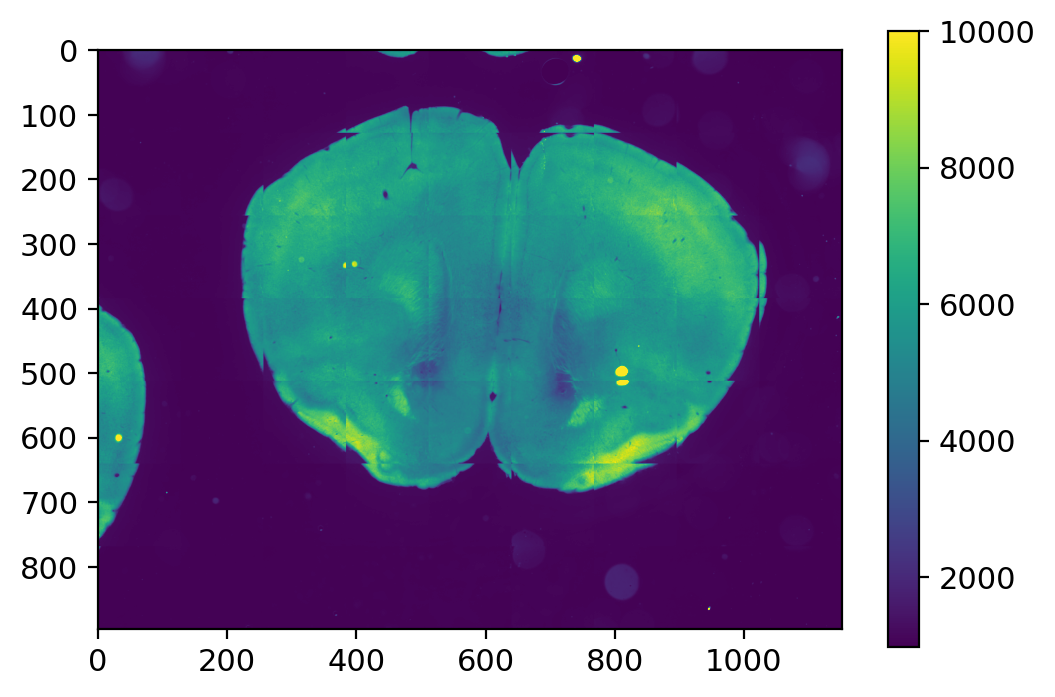

In [15]:
transformed2 = basic.fit_transform(brain_wsi_image)
composed, rows, cols = compose_image(transformed2)
plt.imshow(composed, vmin=970, vmax=10000)
plt.colorbar()

In [18]:
df, props = stitch_images(
    transformed1, rows, cols, row_col_transpose=False, ncc_threshold=0.2
)

100%|██████████| 63/63 [00:00<00:00, 1008.76it/s]


In [20]:
stitched_images = []

for image in [brain_wsi_image, transformed1, transformed2]:
    stitched_image = np.zeros(
        (
            image.shape[1] + df["y_pos"].max(),
            image.shape[2] + df["x_pos"].max(),
        )
    )
    for (_, row), im in zip(df.iterrows(), image):
        stitched_image[
            row["y_pos"] : row["y_pos"] + im.shape[0],
            row["x_pos"] : row["x_pos"] + im.shape[1],
        ] = im
    stitched_images.append(stitched_image)

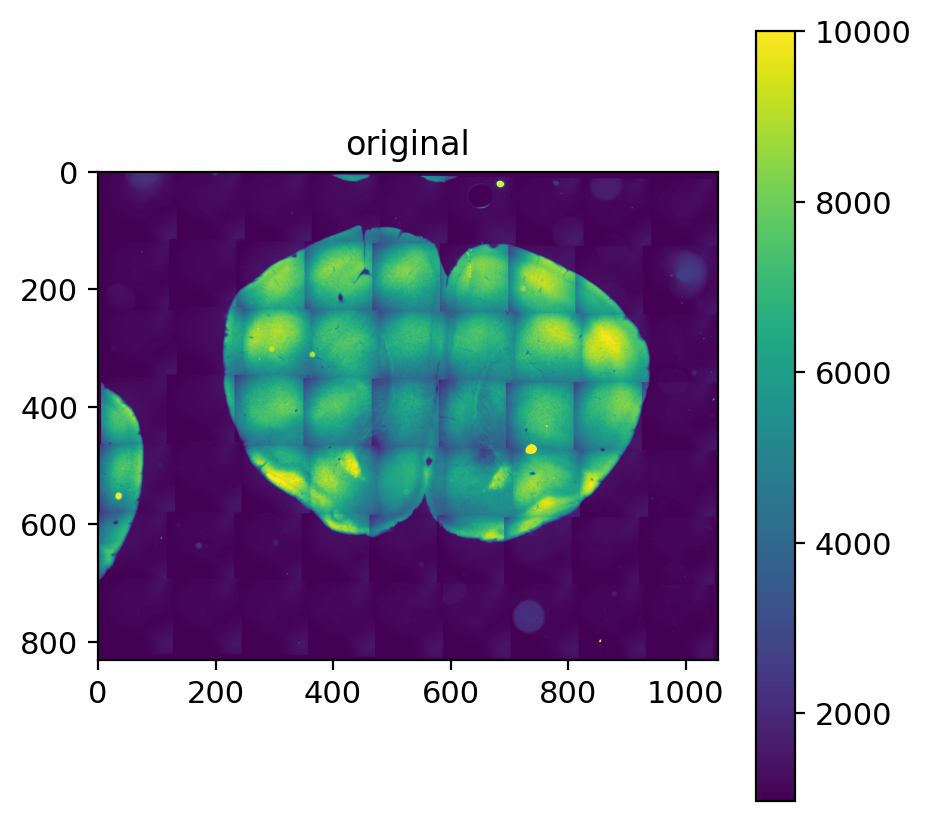

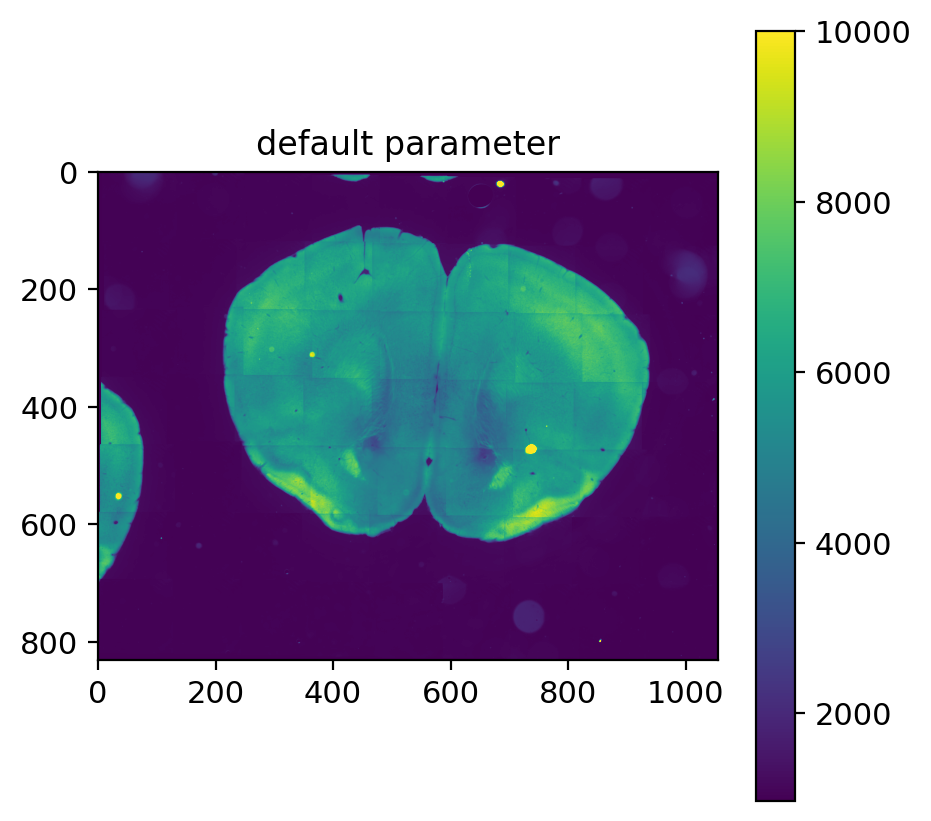

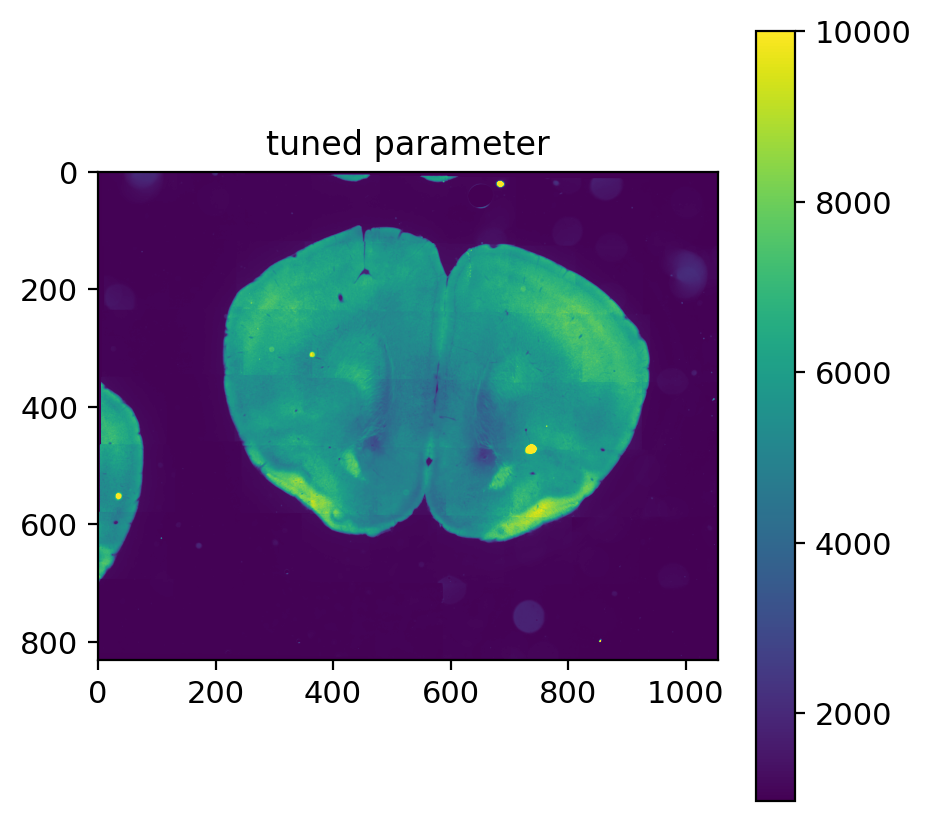

In [22]:
for name, stitched_image in zip(
    ["original", "default parameter", "tuned parameter"], stitched_images
):
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.imshow(stitched_image, vmin=970, vmax=10000)
    plt.colorbar()